# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

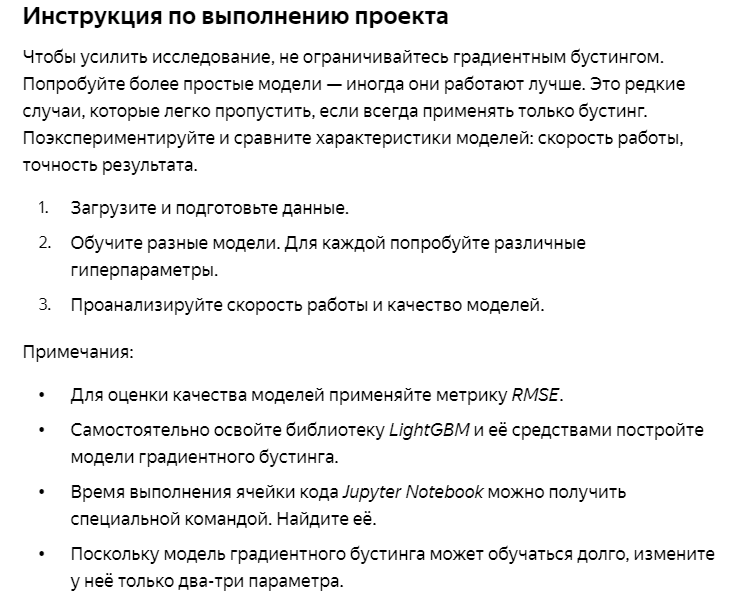

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import time
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

## Подготовка данных

**Описание данных**

Данные находятся в файле /datasets/autos.csv

**Признаки**

**DateCrawled** — дата скачивания анкеты из базы

**VehicleType** — тип автомобильного кузова

**RegistrationYear** — год регистрации автомобиля

**Gearbox** — тип коробки передач

**Power** — мощность (л. с.)

**Model** — модель автомобиля

**Kilometer** — пробег (км)

**RegistrationMonth** — месяц регистрации автомобиля

**FuelType** — тип топлива

**Brand** — марка автомобиля

**NotRepaired** — была машина в ремонте или нет

**DateCreated** — дата создания анкеты

**NumberOfPictures** — количество фотографий автомобиля

**PostalCode** — почтовый индекс владельца анкеты (пользователя)

**LastSeen** — дата последней активности пользователя

Целевой признак

**Price** — цена (евро)

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


### Оставим только нужные для исследования признаки

Думаю некоторые данные уже на первом этапе можно отбросить, так как в определении стоимости автомобился они нам не помогут:

DateCrawled — дата скачивания анкеты из базы

DateCreated — дата создания анкеты

LastSeen — дата последней активности пользователя

PostalCode — почтовый индекс владельца анкеты (пользователя)

In [4]:
del data['DateCreated']
del data['LastSeen']
del data['DateCrawled']
del data['PostalCode']

переименуем колонки датафрейма в приятный вид:

In [5]:
data = data.rename(columns={'Price' : 'price', 'VehicleType' : 'vehicle_type', 'RegistrationYear' : 'registration_year',
                           'Gearbox' : 'gearbox', 'Power' : 'power', 'Model' : 'model', 'Kilometer' : 'kilometer',
                            'RegistrationMonth' : 'registration_month', 'FuelType' : 'fuel_type', 'Brand' : 'brand', 
                            'NotRepaired' : 'not_repaired', 'NumberOfPictures' : 'number_of_pictures'})

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        316879 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             334536 non-null  object
 4   power               354369 non-null  int64 
 5   model               334664 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           321474 non-null  object
 9   brand               354369 non-null  object
 10  not_repaired        283215 non-null  object
 11  number_of_pictures  354369 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.4+ MB


Признаки **registration_year** и **registration_month** чтобы не плодить признаки можно объединить в рамках одного столбца - просто сделать год регистрации типом данных *float* , прибавив к нему часть года, которая пройдет с учётом месяца регситрации. Таким образом мы и не потеряем данные, и избавимся от целого столбца. В них обоих нет пропусков, так что это должно быть легко осуществить

убедимся, что в registration_month адекватные значения - от 0 до 12 месяцев

In [7]:
data['registration_month'].describe()

count    354369.000000
mean          5.714645
std           3.726421
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

выглядит правдиво - можем применить предложенное объединение

In [8]:
data['registration_year'] = data['registration_year'] + data['registration_month']/12

In [9]:
display(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
0,480,NaN,1993.000000,manual,0,golf,150000,0,petrol,volkswagen,NaN,0
1,18300,coupe,2011.416667,manual,190,NaN,125000,5,gasoline,audi,yes,0
2,9800,suv,2004.666667,auto,163,grand,125000,8,gasoline,jeep,NaN,0
3,1500,small,2001.500000,manual,75,golf,150000,6,petrol,volkswagen,no,0
4,3600,small,2008.583333,manual,69,fabia,90000,7,gasoline,skoda,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005.583333,manual,0,colt,150000,7,petrol,mitsubishi,yes,0
354365,2200,NaN,2005.083333,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,0
354366,1199,convertible,2000.250000,auto,101,fortwo,125000,3,petrol,smart,no,0
354367,9200,bus,1996.250000,manual,102,transporter,150000,3,gasoline,volkswagen,no,0


Выглядит оно теперь конечно не так красиво, как раньше, но зато мы сохранили по сути 2 признака в одном, и можем избавиться от лишнего столбца, сэкономив вместо и ускорив дальнейшкую обработку данных

In [10]:
del data['registration_month']

### Удаление дубликатов в данных

In [11]:
data.duplicated().sum()

27670

In [12]:
data = data.drop_duplicates().reset_index(drop = True)

### Анализ признаков, заполнение пропусков

Пройдёмся по порядку по каждому из столбцов и если в них есть пропуски/аномальные значения - решим, что с ними делать

In [13]:
display(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,number_of_pictures
0,480,NaN,1993.000000,manual,0,golf,150000,petrol,volkswagen,NaN,0
1,18300,coupe,2011.416667,manual,190,NaN,125000,gasoline,audi,yes,0
2,9800,suv,2004.666667,auto,163,grand,125000,gasoline,jeep,NaN,0
3,1500,small,2001.500000,manual,75,golf,150000,petrol,volkswagen,no,0
4,3600,small,2008.583333,manual,69,fabia,90000,gasoline,skoda,no,0
...,...,...,...,...,...,...,...,...,...,...,...
326694,0,NaN,2005.583333,manual,0,colt,150000,petrol,mitsubishi,yes,0
326695,2200,NaN,2005.083333,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,0
326696,1199,convertible,2000.250000,auto,101,fortwo,125000,petrol,smart,no,0
326697,9200,bus,1996.250000,manual,102,transporter,150000,gasoline,volkswagen,no,0


первый столбец - целевой признак **price** - стоимость машины в евро

In [14]:
data['price'].describe()

count    326699.000000
mean       4404.886149
std        4518.551506
min           0.000000
25%        1000.000000
50%        2700.000000
75%        6350.000000
max       20000.000000
Name: price, dtype: float64

<AxesSubplot:>

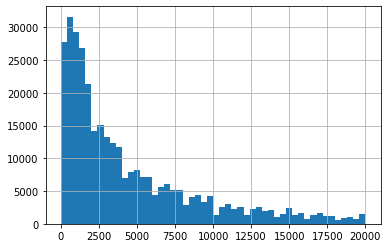

In [15]:
data['price'].hist(bins=50)

Как видно - значения весьма сильно смещены влево - в сторону 0 стоимости. Можно сказать, что при разбросе цен от 0 до 20 000 евро - большинство машин относятся скорее к дешёвым (75 % квантиль = 6350 , то есть почти все цены более чем в 3 раза меньше максимальной). Вопрос конечно состоит в том могут ли действительно машины иметь 0 стоимость, но судя по гистограмме это явно не какие-то аномальные выбросы - около нуля и правда очень много значений, и даже абсолютно нулевую стоимость машины тоже похоже вполне могут выставить. Возможно хотят просто избавиться от налога или техобслуживания 

In [16]:
data['price'].isna().sum()

0

Разброс значений целевого признака проанализирован, пропусков значений в нём нет - можем переходить к следующему столбцу

**vehicle_type** - тип кузова

In [17]:
data['vehicle_type'].isna().sum()

35245

In [18]:
data['vehicle_type'].value_counts()

sedan          83577
small          73425
wagon          59647
bus            26791
convertible    18750
coupe          15115
suv            10976
other           3173
Name: vehicle_type, dtype: int64

Среди возможных значений данного призанка есть вполне удобный "other" для заполнения пропущенных значений. Можно предположить что из доступных вариантов типа кузова клиенты не смогли выбрать нужный, просто не заполнив данный пункт, и таким образом и образовывались NaN - значения

In [19]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

In [20]:
data['vehicle_type'].value_counts()

sedan          83577
small          73425
wagon          59647
other          38418
bus            26791
convertible    18750
coupe          15115
suv            10976
Name: vehicle_type, dtype: int64

следующий признак - год регистрации **registration_year**

In [21]:
data['registration_year'].isna().sum()

0

In [22]:
data['registration_year'].describe()

count    326699.000000
mean       2004.707587
std          91.134549
min        1000.000000
25%        1999.333333
50%        2003.500000
75%        2008.083333
max        9999.583333
Name: registration_year, dtype: float64

<AxesSubplot:>

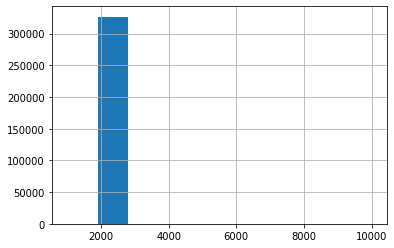

In [23]:
data['registration_year'].hist()

Есть явно весьма аномальные и неправдоподобные значения. Отрежем предварительно точно лишние данные и посмотрим на границы более адекватных значений

In [24]:
shape_before_cutting = data.shape[0]
data = data.query('1950 < registration_year < 2022')
shape_after_cutting = data.shape[0]
print(f'Осталось данных : {(shape_after_cutting/shape_before_cutting)*100} %')

Осталось данных : 99.89929568195801 %


Как видно, выбросов должно было быть не сильно много. Посмотрим на данные ещё раз

In [25]:
data['registration_year'].describe()

count    326370.000000
mean       2003.577103
std           7.399152
min        1950.083333
25%        1999.333333
50%        2003.500000
75%        2008.083333
max        2020.000000
Name: registration_year, dtype: float64

<AxesSubplot:>

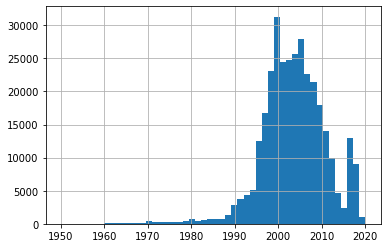

In [26]:
data['registration_year'].hist(bins=50)

Как видно, до 1980 года было зарегистрировано совсем мало автомобилей. Для того чтобы рассмотреть наиболее информативный срез данных оставим для исследовани дипазон 1980 - 2020

In [27]:
data = data.query('1980 < registration_year')

теперь рассмотрим столбец **gearbox** - тип коробки передач

In [28]:
data['gearbox'].isna().sum()

16598

In [29]:
data['gearbox'].value_counts()

manual    245962
auto       60459
Name: gearbox, dtype: int64

Тут какую-то явную логику сложно применить - даже машины одной марки и модели бывают с разными коробками передач. Заполним тут пропущенные строчки значениями "unknown" - всё же пропусков довольно много, чтобы их просто удалять

In [30]:
data['gearbox'] = data['gearbox'].fillna('unknown')

In [31]:
data['gearbox'].value_counts()

manual     245962
auto        60459
unknown     16598
Name: gearbox, dtype: int64

рассмотрим столбец **power** - мощность в лошадиных силах

In [32]:
data['power'].isna().sum()

0

In [33]:
data['power'].describe()

count    323019.000000
mean        110.673329
std         194.372005
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

<AxesSubplot:>

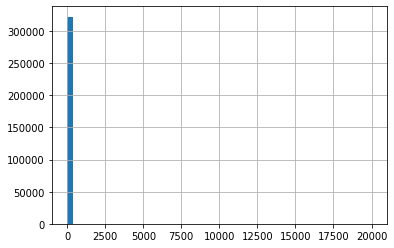

In [34]:
data['power'].hist(bins=50)

Явно можем сказать, что не может быть 20 000 л.с. у машины, как и абсолютного 0. Посмотрим как разбросаны данные

<AxesSubplot:>

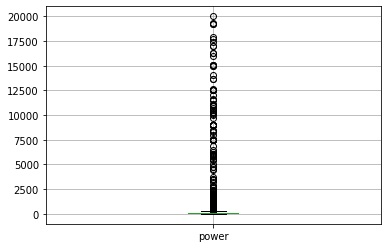

In [35]:
data.boxplot(column='power')

Как видно, большие значения мощностей встречаются фактически на всём диапазоне до 20 000, так что нельзя сказать что выбросы как-то локализированы

<AxesSubplot:>

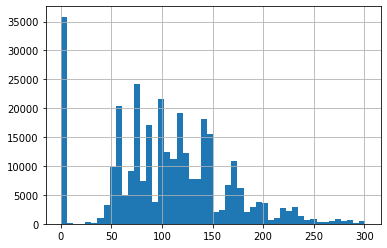

In [36]:
data['power'].hist(bins=50, range=(0,301))

Можем сказать, что резонный для рассмотрения диапазон лежит где-то между 25 и 300 лошалиными силами. По свободным источникам в среднем данный параметр должен быть 90 - 150 у машины, так что такая выборка должна вполне покрывать все разумные отклонения от данного диапазона. А вот скопление нулей и слишком аномальных по величине лошадиных сил - удалим

In [37]:
shape_before_cutting = data.shape[0]
data = data.query('25 < power < 300')
shape_after_cutting = data.shape[0]
print(f'Осталось данных : {(shape_after_cutting/shape_before_cutting)*100} %')

Осталось данных : 87.79947928759609 %


In [38]:
data['power'].describe()

count    283609.000000
mean        117.908963
std          48.258049
min          26.000000
25%          75.000000
50%         110.000000
75%         146.000000
max         299.000000
Name: power, dtype: float64

<AxesSubplot:>

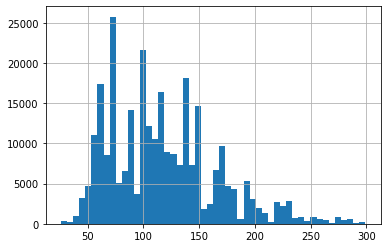

In [39]:
data['power'].hist(bins=50)

Что ж, данных мы потеряли много, но зато оставшиеся можно действительно считать правдоподобными для построения модели и работы

следюущий столбец - **model** , модель машины

In [40]:
data['model'].isna().sum()

11914

In [41]:
data['model'].value_counts()

golf                  24142
other                 18591
3er                   16478
polo                  10420
corsa                  9685
                      ...  
samara                    5
kalina                    4
serie_2                   3
rangerover                3
range_rover_evoque        1
Name: model, Length: 248, dtype: int64

Что ж, можем сказать, что тут так же есть некое значение "other", которое вполне можно предположить кем-то ранее было выделено для таких клиентов, которые ничего не написали в модели машины. Пусть и те, кто сейчас остались с параметром NaN в данном признаке - будут отправлены туда

In [42]:
data['model'] = data['model'].fillna('other')

далее идём столбец **kilometer** - пробег в км

In [43]:
data['kilometer'].isna().sum()

0

In [44]:
data['kilometer'].describe()

count    283609.000000
mean     128782.778403
std       36522.651772
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

<AxesSubplot:>

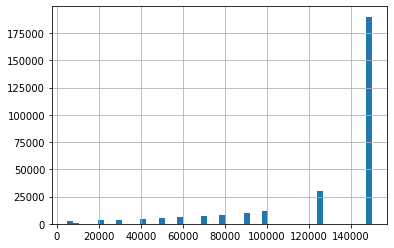

In [45]:
data['kilometer'].hist(bins=50)

Данные конечно выглядят, как словно искусственно округленные, но в целом как-то ещё осудить данный столбец нельзя

далее идёт **fuel_type** - тип топлива

In [46]:
data['fuel_type'].value_counts()

petrol      176312
gasoline     82150
lpg           4258
cng            467
hybrid         200
other           75
electric        39
Name: fuel_type, dtype: int64

In [47]:
data['fuel_type'].isna().sum()

20108

Что ж, воспользуемся ранее применённой логикой

In [48]:
data['fuel_type'] = data['fuel_type'].fillna('other')

In [49]:
data['fuel_type'].value_counts()

petrol      176312
gasoline     82150
other        20183
lpg           4258
cng            467
hybrid         200
electric        39
Name: fuel_type, dtype: int64

далее идёт столбец **brand** - соответственно, бренд автомобиля

In [50]:
data['brand'].isna().sum()

0

In [51]:
data['brand'].value_counts()

volkswagen        61996
opel              31626
bmw               30190
mercedes_benz     25222
audi              24197
ford              19993
renault           13767
peugeot            9031
fiat               7423
seat               5795
skoda              4707
mazda              4641
smart              4354
citroen            4192
nissan             3920
toyota             3907
hyundai            3002
mini               2816
volvo              2647
mitsubishi         2510
honda              2413
kia                2028
alfa_romeo         1926
suzuki             1922
chevrolet          1339
sonstige_autos     1199
chrysler           1131
dacia               767
subaru              640
daihatsu            617
jeep                536
saab                449
land_rover          426
daewoo              407
porsche             378
jaguar              378
lancia              375
rover               373
trabant             234
lada                135
Name: brand, dtype: int64

Тут всё выглядит вполне хорошо

далее идёт **not_repaired** - была ли машина в ремонте или нет

In [52]:
data['not_repaired'].isna().sum()

45934

In [53]:
data['not_repaired'].value_counts()

no     208449
yes     29226
Name: not_repaired, dtype: int64

Тут довольно сложно сказать, почему человек не указал данный момент - это может быть как действительно отсутствие ремонтных работ, так и попытка не указывать их присутствие. Так как кол-во пропусков весьма большое и просто удалять такие строки жалко, предлагаю ввести для скрывших свою реальную историю починок автомобиля клиентов категорию *not_mentioned* - по идее не выставляющие в открытый доступ информацию о ремонте машины клиенты при продаже это тоже вполне себе отдельная категория, на котрую должным образом реагируют потенциальные покупатели, начиная относиться с осторожностью к такому объявлению

In [54]:
data['not_repaired'] = data['not_repaired'].fillna('not_metioned')

In [55]:
data['not_repaired'].value_counts()

no              208449
not_metioned     45934
yes              29226
Name: not_repaired, dtype: int64

и последний столбец - **number_of_pictures** - кол-во фото автомлбиля

In [56]:
data['number_of_pictures'].isna().sum()

0

In [57]:
data['number_of_pictures'].value_counts()

0    283609
Name: number_of_pictures, dtype: int64

похоже на какой-то столбец с поврежденными данными, где число фото забыли выгрузить. но так как связаться с потенциальным заказчиком мы не можем для уточнения такой странности, то остается только разве что удалить такой столбец, так как никакой информативности он очевидно не вносит в обучение модели

In [58]:
del data['number_of_pictures']

Посмотрим на данные после обработки ещё раз перед дальнейшим обучением моделей

In [59]:
display(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
1,18300,coupe,2011.416667,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004.666667,auto,163,grand,125000,gasoline,jeep,not_metioned
3,1500,small,2001.500000,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008.583333,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995.833333,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
326692,5250,other,2017.000000,auto,150,159,150000,other,alfa_romeo,no
326693,3200,sedan,2004.416667,manual,225,leon,150000,petrol,seat,yes
326696,1199,convertible,2000.250000,auto,101,fortwo,125000,petrol,smart,no
326697,9200,bus,1996.250000,manual,102,transporter,150000,gasoline,volkswagen,no


In [60]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
dtype: int64

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283609 entries, 1 to 326698
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              283609 non-null  int64  
 1   vehicle_type       283609 non-null  object 
 2   registration_year  283609 non-null  float64
 3   gearbox            283609 non-null  object 
 4   power              283609 non-null  int64  
 5   model              283609 non-null  object 
 6   kilometer          283609 non-null  int64  
 7   fuel_type          283609 non-null  object 
 8   brand              283609 non-null  object 
 9   not_repaired       283609 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 23.8+ MB


## Обучение моделей

### Для начала попробуем обучить обычные модели, не применяя градиентный бустинг - например случайный лес и линейную регрессию

Преобразуем имеющиеся категориальные признаки в количественные:

In [62]:
data_ohe = data.copy(deep=True)
data_ohe = pd.get_dummies(data_ohe, drop_first=True)

Разделим признаки на обучающую, тестовую и тренировочную выборки (пусть 60 % будут обучающими, и по 20 % для валидационной и тестовой выборки:

In [63]:
train, validate, test = np.split(data_ohe.sample(frac=1, random_state=42), [int(0.6*len(data_ohe)), int(0.8*len(data_ohe))])

In [64]:
train.shape, validate.shape, test.shape

((170165, 307), (56722, 307), (56722, 307))

In [65]:
features_train = train.drop(['price'], axis=1)
target_train = train['price']
features_validate = validate.drop(['price'], axis=1)
target_validate = validate['price']
features_test = test.drop(['price'], axis=1)
target_test = test['price']

Для начала обучим модель линейной регрессии. Будем фиксировать время обучения и предсказания

In [66]:
linear_regressor_model = LinearRegression()

In [67]:
%%time
start_time = time.perf_counter()
linear_regressor_model.fit(features_train, target_train)
finish_time = time.perf_counter()
linear_regressor_fit_time = str(int((finish_time - start_time)//60)) + ' : ' + str(int((finish_time - start_time)%60))

CPU times: user 18.7 s, sys: 12.3 s, total: 31 s
Wall time: 31.2 s


In [68]:
%%time
start_time = time.perf_counter()
predictions_linear_regressor = linear_regressor_model.predict(features_validate)
finish_time = time.perf_counter()
linear_regressor_predict_time = (finish_time - start_time)

CPU times: user 117 ms, sys: 62.9 ms, total: 180 ms
Wall time: 183 ms


In [69]:
rmse_linear_regressor = mean_squared_error(target_validate, predictions_linear_regressor)**0.5

In [70]:
print(f'Метрика RMSE для линейной регрессии : {rmse_linear_regressor:.3f}')

Метрика RMSE для линейной регрессии : 2483.238


Что ж, значение кажется довольно большим - будем надеяться, у случайного леса получится лучше

Проверим насколько вообще были адекватны полученные нами показатели на "глупой" модели, которая будет предсказывать просто среднее значение в качестве ответов

In [71]:
dummy_regressor = DummyRegressor(strategy="mean")

In [72]:
dummy_regressor.fit(features_train, target_train)
predictions_dummy_regressor = dummy_regressor.predict(features_validate)
rmse_dummy_regressor_model = mean_squared_error(target_validate, predictions_dummy_regressor)**0.5

In [73]:
print(f'Предсказания "глупой" модели, которая брала просто средние значения правильных ответов: {rmse_dummy_regressor_model:.3f}')

Предсказания "глупой" модели, которая брала просто средние значения правильных ответов: 4501.744


Можем сказать, что сделанные предсказания выше на обученной модели показывают гораздо лучший результат, и значит в их обучении действительно есть смысл

Обучим модель случайного леса:

In [74]:
model_forest = RandomForestRegressor(random_state=12345)

In [75]:
# зададим диапазоны поиска оптимальных параметров - данных очень много, поэтому не будем сильно нагружать систему
max_depth = [10, 15, 20, 25]                   
max_trees = [10, 15, 20, 25] 

forest_params = {'max_depth': max_depth, 'n_estimators': max_trees}

In [76]:
forest_grid_model = GridSearchCV(model_forest, forest_params, cv=3, scoring='neg_mean_squared_error')

In [77]:
%%time
start_time = time.perf_counter()
forest_grid_model.fit(features_train, target_train)
finish_time = time.perf_counter()
forest_grid_fit_time = str(int((finish_time - start_time)//60)) + ' : ' + str(int((finish_time - start_time)%60))

CPU times: user 32min 52s, sys: 10 s, total: 33min 2s
Wall time: 33min 44s


In [78]:
%%time
start_time = time.perf_counter()
predictions_forest_grid_model = forest_grid_model.predict(features_validate)
finish_time = time.perf_counter()
forest_grid_predict_time = (finish_time - start_time)

CPU times: user 574 ms, sys: 52 ms, total: 626 ms
Wall time: 736 ms


In [79]:
rmse_grid_forest = mean_squared_error(target_validate, predictions_forest_grid_model)**0.5

In [80]:
print(f'Метрика RMSE для случайного леса : {rmse_grid_forest:.3f}')

Метрика RMSE для случайного леса : 1701.216


Не то что бы тоже точный показатель, но уже гораздо лучше, чем у линейной регрессии

### Обучение модели градиентного бустинга

Первой обучим модель LightBoost:

In [81]:
lgb_regressor_model = lgb.LGBMRegressor(objective='regression', metric='l2')

In [82]:
max_depth = [10, 15, 20, 25]       # возьмём в качестве гиперпараметров максимальную глубину и величину шага
learning_rate = [0.05, 0.1, 0.15]
lgb_params = {'max_depth': max_depth, 'learning_rate' : learning_rate}
grid_lgb_model = GridSearchCV(lgb_regressor_model, param_grid=lgb_params, scoring='neg_mean_squared_error', cv=3)

In [83]:
%%time
start_time = time.perf_counter()
grid_lgb_model.fit(features_train, target_train)
finish_time = time.perf_counter()
grid_lgb_fit_time = str(int((finish_time - start_time)//60)) + ' : ' + str(int((finish_time - start_time)%60))

CPU times: user 52min 52s, sys: 24.2 s, total: 53min 16s
Wall time: 53min 32s


In [84]:
%%time
start_time = time.perf_counter()
predictions_grid_lgb_model = grid_lgb_model.predict(features_validate)
finish_time = time.perf_counter()
grid_lgb_predict_time = (finish_time - start_time)

CPU times: user 835 ms, sys: 68.8 ms, total: 903 ms
Wall time: 912 ms


In [85]:
rmse_grid_lgb_model = mean_squared_error(target_validate, predictions_grid_lgb_model)**0.5

In [86]:
print(f'Метрика RMSE для модели LGBM : {rmse_grid_lgb_model:.3f}')

Метрика RMSE для модели LGBM : 1674.981


Теперь попробуем обучить модель Catboost, который сам умеет делать предсказания по категориальным признакам

In [87]:
cat_regressor_model = CatBoostRegressor(loss_function='RMSE')

Теперь уже возьмём датафрейм без применения ohe - доверимся самому catboost

In [88]:
display(data)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
1,18300,coupe,2011.416667,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004.666667,auto,163,grand,125000,gasoline,jeep,not_metioned
3,1500,small,2001.500000,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008.583333,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995.833333,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
326692,5250,other,2017.000000,auto,150,159,150000,other,alfa_romeo,no
326693,3200,sedan,2004.416667,manual,225,leon,150000,petrol,seat,yes
326696,1199,convertible,2000.250000,auto,101,fortwo,125000,petrol,smart,no
326697,9200,bus,1996.250000,manual,102,transporter,150000,gasoline,volkswagen,no


In [89]:
train, validate, test = np.split(data.sample(frac=1, random_state=42), [int(0.6*len(data)), int(0.8*len(data))])

In [90]:
features_train = train.drop(['price'], axis=1)
target_train = train['price']
features_validate = validate.drop(['price'], axis=1)
target_validate = validate['price']
features_test = test.drop(['price'], axis=1)
target_test = test['price']

In [91]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [92]:
%%time
start_time = time.perf_counter()
cat_regressor_model.fit(features_train, target_train, cat_features = cat_features, verbose = 0)
finish_time = time.perf_counter()
cat_model_fit_time = str(int((finish_time - start_time)//60)) + ' : ' + str(int((finish_time - start_time)%60))

CPU times: user 7min 26s, sys: 868 ms, total: 7min 27s
Wall time: 7min 33s


In [93]:
%%time
start_time = time.perf_counter()
predictions_cat_regressor_model = cat_regressor_model.predict(features_validate)
finish_time = time.perf_counter()
cat_model_predict_time = (finish_time - start_time)

CPU times: user 847 ms, sys: 0 ns, total: 847 ms
Wall time: 864 ms


In [94]:
rmse_cat_model = mean_squared_error(target_validate, predictions_cat_regressor_model)**0.5

In [95]:
print(f'Метрика RMSE модели Catboost : {rmse_cat_model}')

Метрика RMSE модели Catboost : 1628.338320127136


Как видно, Catboost показал ещё более классную метрику и он явно хорош, да и время обучения довольно быстрое. Явно стоит использовать его в дальнейшем почаще

Посмотрим как распределена важность признаков, влияющих на предсказание:

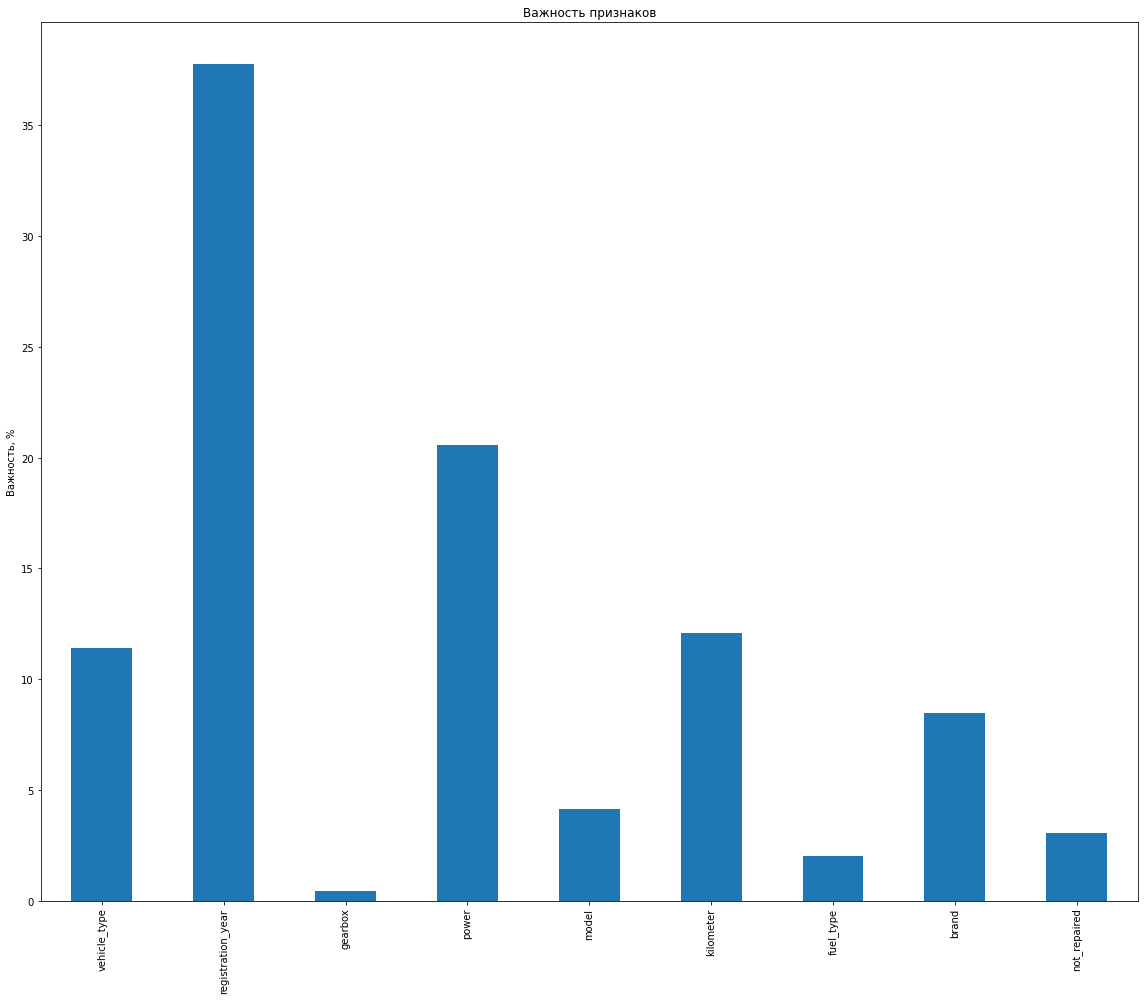

In [96]:
cat_iris_imp = pd.Series(cat_regressor_model.get_feature_importance(),
                         features_train.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Что ж, выглядит оно вполне добротно и даёт довольно интересную информацию насколько на стоимость машины повлиял тот или иной признак - думаю вполне важные и интересные данные для любого заказчика. В основном это год регистрации и мощность, что вполне правдоподобно

## Анализ моделей

Выведем сводную таблицу со всеми получившимися показателями исследованнаых моделей для их сравнения:

In [97]:
models_stats = {'linear_regression' : [rmse_linear_regressor, linear_regressor_fit_time, linear_regressor_predict_time],
               'random_forest' : [rmse_grid_forest, forest_grid_fit_time, forest_grid_predict_time],
               'LGBM' : [rmse_grid_lgb_model, grid_lgb_fit_time, grid_lgb_predict_time],
               'Catboost' : [rmse_cat_model, cat_model_fit_time, cat_model_predict_time]}
dataframe = pd.DataFrame(models_stats, index=['значение RMSE', 'время обучения (минуты:секунды)', 'время предсказания (секунды)'])
display(dataframe)

,linear_regression,random_forest,LGBM,Catboost
значение RMSE,2483.23831,1701.216405,1674.980739,1628.33832
время обучения (минуты:секунды),0 : 31,33 : 44,53 : 32,7 : 33
время предсказания (секунды),0.182698,0.736239,0.911756,0.86381


Как видно - лучше всех оказался Catboost, при этом у него даже довольно маленькое время обучения. Используем на тестовой выборке именно его

In [98]:
predictions_cat_regressor_model = cat_regressor_model.predict(features_test)
rmse_cat_regressor_model = mean_squared_error(target_test, predictions_cat_regressor_model)**0.5

In [99]:
print(f'Показатель RMSE модели catboost на тестовой выборке: {rmse_cat_regressor_model:.3f}')

Показатель RMSE модели catboost на тестовой выборке: 1675.172


Что ж, более-менее ожидаемый резульат - получили почти то же значение метрики, что и на валидационной выборке